In [25]:
import torch
from sklearn.metrics import precision_recall_curve

filename = "activation_values.pt"

activations = torch.load(filename, map_location='cpu')
activations

/tmp/ipykernel_481288/53618906.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load(filename, map_location='cpu')


{'config': {'random_seed': 42,
  'intervention_types': ['conditional_per_token',
   'probe_sae',
   'conditional_steering_vector'],
  'model_name': 'meta-llama/Llama-3.1-8B-Instruct',
  'scales': [-2, -3, -4, -5, -6, -7, -8, -10, -20, -40],
  'batch_size': 20,
  'total_generations': 200,
  'max_new_tokens': 400,
  'prompt_filename': 'prompt_no_regex.txt',
  'docs_filename': 'pytest_docs.txt',
  'code_filename': 'code.json',
  'contrastive_prompts_filename': 'contrastive_prompts.json',
  'probe_prompts_filename': 'probe_prompts.json',
  'prefill': '```python\n',
  'prompt_folder': 'src/prompts',
  'prompt_type': 'regex',
  'encoder_threshold_bias': 0.0,
  'steering_vector_threshold_bias': -150.0,
  'use_llm_judge': False,
  'save_path': 'activation_values.pt'},
 'conditional_per_token': {'not_regex_1': tensor([-1.8516, -0.3906, -0.4824,  ..., -0.8320, -2.4844, -2.4219],
         dtype=torch.bfloat16),
  'regex_1': tensor([-1.8516, -0.3906, -0.4824,  ...,  2.0938,  0.8516,  2.8906],
    

In [26]:
print(activations.keys())

label_lookup = {
    "conditional_per_token": "SAE Classifier",
    "conditional_steering_vector": "Steering Vector Classifier",
    "probe_sae": "Probe Classifier"
}

dict_keys(['config', 'conditional_per_token', 'probe_sae', 'conditional_steering_vector'])


In [27]:
acts_data = {}

for intervention_type in activations:
    if intervention_type == "config":
        continue

    acts_data[intervention_type] = {"with_regex": [], "without_regex": [], "questions": []}

    for i, code_key in enumerate(activations[intervention_type]):
        acts_L = activations[intervention_type][code_key]
        if "not_regex" in code_key:
            acts_data[intervention_type]["without_regex"].append(acts_L)
        elif "question" in code_key:
            acts_data[intervention_type]["questions"].append(acts_L)
        else:
            acts_data[intervention_type]["with_regex"].append(acts_L)
        

for intervention_type in acts_data:
    print(intervention_type)
    acts_data[intervention_type]["with_regex"] = torch.cat(acts_data[intervention_type]["with_regex"]).cpu().float()
    questions = torch.cat(acts_data[intervention_type]["questions"]).cpu().float()
    without_regex = torch.cat(acts_data[intervention_type]["without_regex"]).cpu().float()
    acts_data[intervention_type]["without_regex"] = torch.cat([without_regex, questions]).cpu().float()

conditional_per_token
probe_sae
conditional_steering_vector


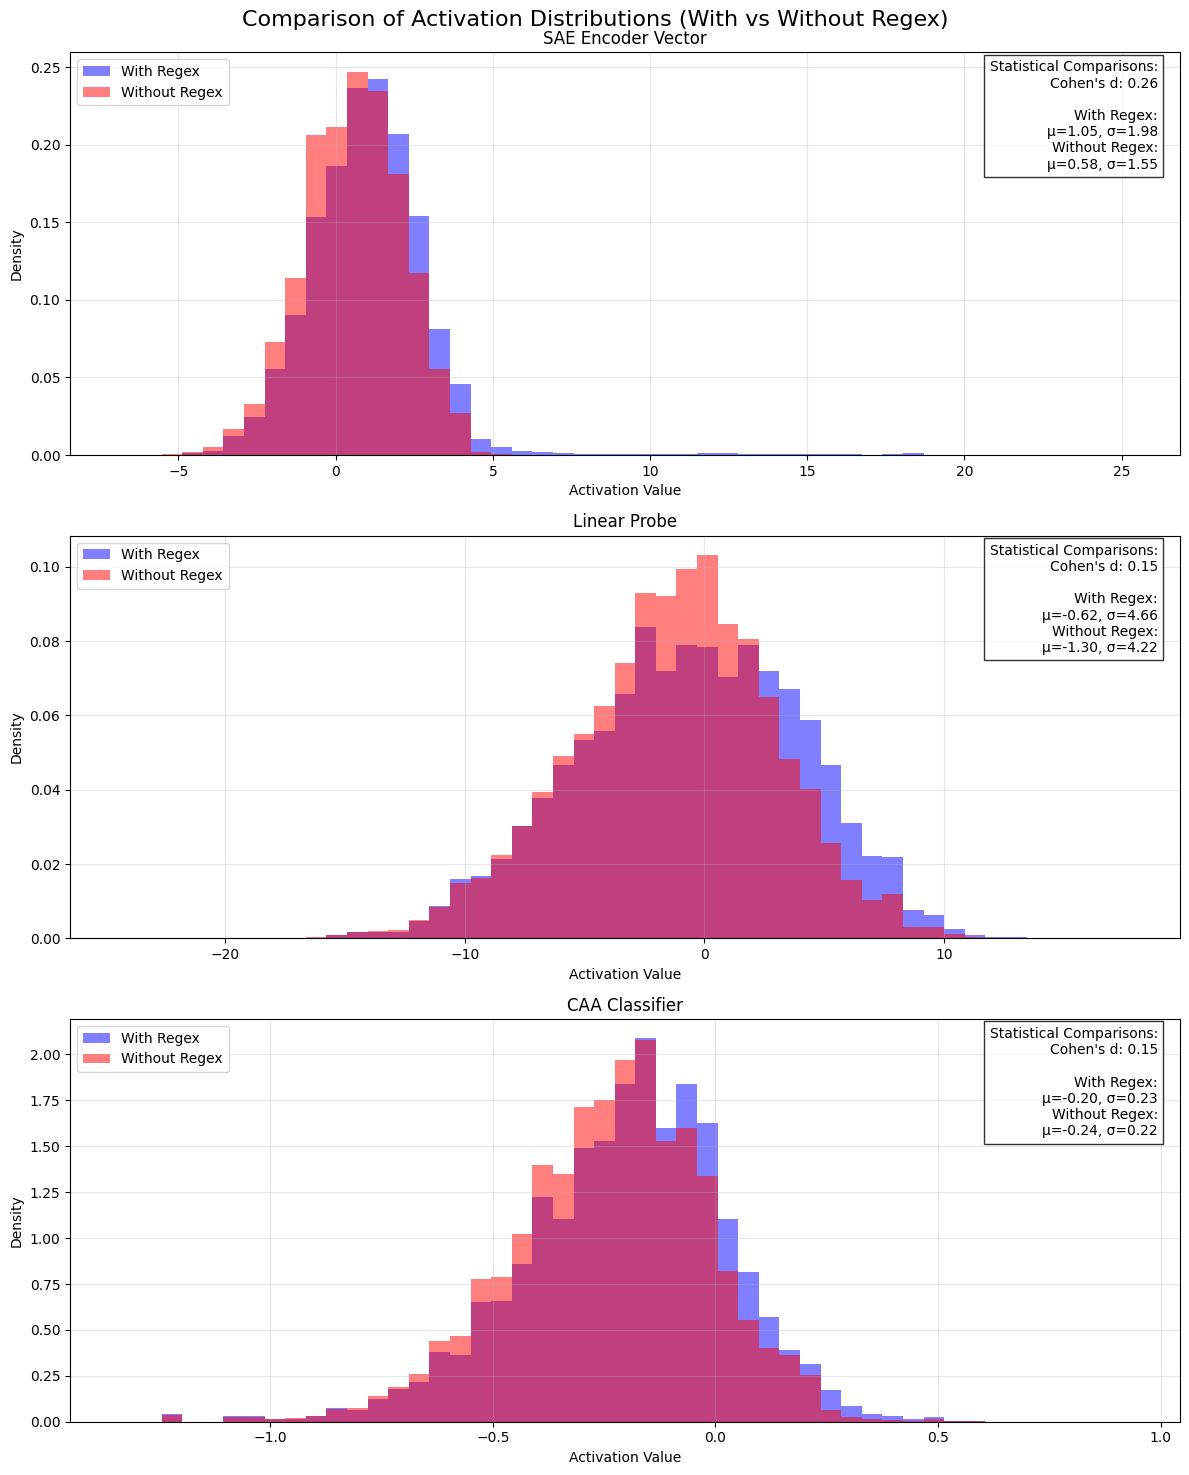

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

method_mapping = {
    "conditional_per_token": "SAE Encoder Vector",
    "probe_sae": "Linear Probe",
    "conditional_steering_vector": "CAA Classifier",
}

def compare_activation_distributions(acts_data):
    # Calculate number of intervention types
    n_types = len(acts_data)
    
    # Create figure
    fig, axes = plt.subplots(n_types, 1, figsize=(12, 5*n_types))
    fig.suptitle('Comparison of Activation Distributions (With vs Without Regex)', fontsize=16)
    
    # If there's only one intervention type, wrap axes in a list
    if n_types == 1:
        axes = [axes]
    
    for i, (intervention_type, data) in enumerate(acts_data.items()):
        # Get data
        with_regex_data = data['with_regex'].flatten().numpy()
        
        # Create histogram bins that cover both distributions
        if len(data['without_regex']) > 0:
            without_regex_data = data['without_regex'].flatten().numpy()
            all_data = np.concatenate([with_regex_data, without_regex_data])
            bins = np.linspace(np.min(all_data), np.max(all_data), 50)
            
            # Plot overlapping histograms
            axes[i].hist(with_regex_data, bins=bins, alpha=0.5, label='With Regex', 
                        density=True, color='blue')
            axes[i].hist(without_regex_data, bins=bins, alpha=0.5, label='Without Regex', 
                        density=True, color='red')
            
            # Perform statistical tests
            # ks_stat, ks_pval = stats.ks_2samp(with_regex_data, without_regex_data)
            # t_stat, t_pval = stats.ttest_ind(with_regex_data, without_regex_data)
            
            # Calculate effect size (Cohen's d)
            cohens_d = (np.mean(with_regex_data) - np.mean(without_regex_data)) / \
                      np.sqrt((np.var(with_regex_data) + np.var(without_regex_data)) / 2)
            
            # Add statistical information
            stats_text = (
                f"Statistical Comparisons:\n"
                # f"KS-test: p={ks_pval:.2e}\n"
                # f"t-test: p={t_pval:.2e}\n"
                f"Cohen's d: {cohens_d:.2f}\n\n"
                f"With Regex:\n"
                f"μ={np.mean(with_regex_data):.2f}, σ={np.std(with_regex_data):.2f}\n"
                f"Without Regex:\n"
                f"μ={np.mean(without_regex_data):.2f}, σ={np.std(without_regex_data):.2f}"
            )
            
            axes[i].text(0.98, 0.98, stats_text,
                        transform=axes[i].transAxes,
                        verticalalignment='top',
                        horizontalalignment='right',
                        bbox=dict(facecolor='white', alpha=0.8),
                        fontsize=10)
        else:
            axes[i].hist(with_regex_data, bins=50, alpha=0.5, label='With Regex', 
                        density=True, color='blue')
            axes[i].text(0.5, 0.5, 'No "Without Regex" data available', 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=axes[i].transAxes)
        
        axes[i].set_title(f'{method_mapping[intervention_type]}')
        axes[i].set_xlabel('Activation Value')
        axes[i].set_ylabel('Density')
        axes[i].legend()
        
        # Add grid for better readability
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Use the function
compare_activation_distributions(acts_data)

In [29]:
for intervention_type in acts_data:
    without_regex_data = acts_data[intervention_type]["without_regex"]
    with_regex_data = acts_data[intervention_type]["with_regex"]

    max_val = torch.max(without_regex_data)
    num_activations = (with_regex_data > max_val).sum()

    print(f"Intervention Type: {intervention_type}, Num Activations: {num_activations}, Max Activation: {max_val}")


Intervention Type: conditional_per_token, Num Activations: 545, Max Activation: 19.75
Intervention Type: probe_sae, Num Activations: 0, Max Activation: 17.75
Intervention Type: conditional_steering_vector, Num Activations: 0, Max Activation: 0.9296875


In [30]:
min_precision = 0.999

for intervention_type in acts_data:
    # Skip if no data
    if len(acts_data[intervention_type]["without_regex"]) == 0:
        continue
        
    # Prepare data
    without_regex_data = acts_data[intervention_type]["without_regex"].flatten()
    with_regex_data = acts_data[intervention_type]["with_regex"].flatten()
    
    # Create labels
    y_true = torch.cat([torch.ones_like(with_regex_data), 
                       torch.zeros_like(without_regex_data)]).numpy()
    scores = torch.cat([with_regex_data, without_regex_data]).numpy()
    
    # Calculate PR curve
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    
    # Find threshold where precision > min_precision
    high_precision_idx = np.where(precision > min_precision)[0]
    if len(high_precision_idx) > 0:
        # Take the threshold that gives highest recall while maintaining precision
        best_idx = high_precision_idx[0]
        threshold = thresholds[best_idx - 1] if best_idx > 0 else thresholds[0]
        
        # Apply threshold and count TP/FP
        predictions = (scores >= threshold)
        true_positives = np.sum((predictions == 1) & (y_true == 1))
        false_positives = np.sum((predictions == 1) & (y_true == 0))
        
        print(f"\n{label_lookup[intervention_type]}:")
        print(f"Threshold for {min_precision * 100}% precision: {threshold:.6f}")
        print(f"True Positives: {true_positives}")
        print(f"True positive rate: {true_positives / 420}")
        print(f"False Positives: {false_positives}")
    else:
        print(f"\n{label_lookup[intervention_type]}:")
        print(f"No threshold found that achieves {min_precision * 100}% precision")


SAE Classifier:
Threshold for 99.9% precision: 7.687500
True Positives: 16286
True positive rate: 38.77619047619048
False Positives: 17

Probe Classifier:
Threshold for 99.9% precision: 17.750000
True Positives: 0
True positive rate: 0.0
False Positives: 1

Steering Vector Classifier:
Threshold for 99.9% precision: 0.929688
True Positives: 1
True positive rate: 0.002380952380952381
False Positives: 1


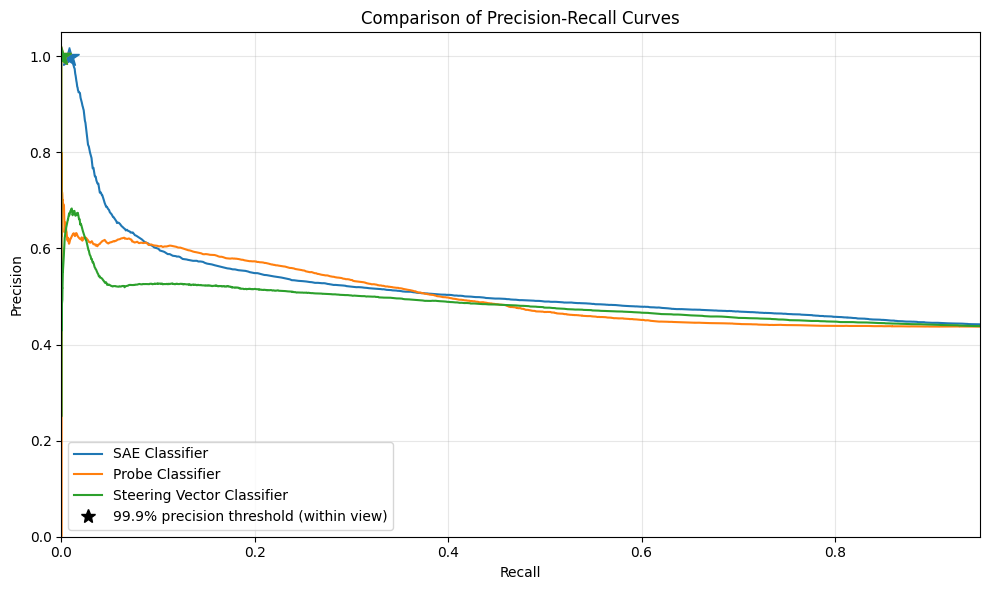

In [32]:
def plot_combined_pr_curves(acts_data, second_key: str = "without_regex"):
    plt.figure(figsize=(10, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Default matplotlib colors
    
    # First plot the PR curves
    for idx, intervention_type in enumerate(acts_data):
        if len(acts_data[intervention_type][second_key]) == 0:
            continue
            
        # Prepare data
        without_regex_data = acts_data[intervention_type][second_key].flatten()
        with_regex_data = acts_data[intervention_type]["with_regex"].flatten()
        
        # Create labels
        y_true = torch.cat([torch.ones_like(with_regex_data), 
                           torch.zeros_like(without_regex_data)]).numpy()
        scores = torch.cat([with_regex_data, without_regex_data]).numpy()
        
        # Calculate PR curve
        precision, recall, thresholds = precision_recall_curve(y_true, scores)
        
        # Plot PR curve
        plt.plot(recall, precision, 
                color=colors[idx],
                label=f'{label_lookup[intervention_type]}')
        
        # Find and plot threshold point with star marker
        high_precision_idx = np.where(precision > min_precision)[0]
        if len(high_precision_idx) > 0:
            best_idx = high_precision_idx[0]
            high_precision_recall = recall[best_idx]
            
            # If recall is beyond our x-axis limits, plot at the right edge
            if high_precision_recall > 0.03:
                plt.plot(0.03, precision[best_idx], 
                        marker='>', markersize=15, 
                        color=colors[idx])
            else:
                plt.plot(high_precision_recall, precision[best_idx], 
                        marker='*', markersize=15, 
                        color=colors[idx])
    
    # Add dummy points for legend
    plt.plot([], [], marker='*', markersize=10, color='black', linestyle='none',
            label=f'{(min_precision * 100):.1f}% precision threshold (within view)')
    # plt.plot([], [], marker='>', markersize=10, color='black', linestyle='none',
    #         label=f'{(min_precision * 100):.1f}% precision threshold (off screen)')
    
    plt.xlim([0.0, 0.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Comparison of Precision-Recall Curves')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("pr_curves.png")
    plt.show()

# Run the combined plot
plot_combined_pr_curves(acts_data, "without_regex")